# Sanity Check

In [1]:
random_seed=42

## Preparing data and black (In Orange framework, it is simple and good)

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

def f(x,y):
        return np.sin(10 * x) + np.cos(4 * y)  - np.cos(3*x*y) 

def predict(X):
    def f_binary(x):
        return int(1) if np.sin(10 * x[0]) + np.cos(4 * x[1])  - np.cos(3*x[0]*x[1]) >= 0 else int(0)
  
    X = np.array(X)
    if X.ndim == 1:
        y = f_binary(X)
    elif X.ndim==2:
        y = np.array(list(map(f_binary, X )) )
    else:
        print("error, blackbox function")
    return y



prepare the dataset and the data encoder

In [3]:
%load_ext autoreload
%autoreload 2
from prepare_dataset import prepare_2d_sinusoidal_dataset
from utils import encoder_from_datatable



data_table,test_data_table = prepare_2d_sinusoidal_dataset()


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# in this case the encoder is only a void passing, nothing is changed since 2-d dataset is simple two continuous variable

categorical_features_idx = [i for i,a in enumerate(data_table.domain.attributes) if a.is_discrete]

scikit_encoder = make_column_transformer(
                            ( OneHotEncoder(categories='auto'),categorical_features_idx),
                            remainder = 'passthrough'
                            )
scikit_encoder.fit(data_table.X)

black_box = lambda x:  predict(scikit_encoder.transform(x))

print("now start sanity-check")
print("the first row of the dataset is (orginal form):\n", data_table[0] )
print("the first row of the dataset is (only X data):\n", data_table.X[0])
print("the first row of the dataset is (transformed by the encoder, it should not change since the encoder is void):\n ",scikit_encoder.transform([data_table.X[0]] ))
print("the predition of blackbox on the first row:\n", black_box( [data_table.X[0]]  )   )



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
now start sanity-check
the first row of the dataset is (orginal form):
 [0.975, 1.7 | yes]
the first row of the dataset is (only X data):
 [0.975 1.7  ]
the first row of the dataset is (transformed by the encoder, it should not change since the encoder is void):
  [[0.9750000000000001 1.7000000000000002]]
the predition of blackbox on the first row:
 [1]


## Passive meth

### Interpretable Decision Set

In [43]:
%load_ext autoreload
%autoreload 2

from competition_methods_explanation.passive_methods.ids import explain_tabular
iter_max = 1000
# explanations = explain_tabular(disc_data_table, black_box, target_class_idx=1, random_seed=random_seed)
explanations = explain_tabular(data_table, black_box, target_class_idx=1, random_seed=random_seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
discre
start Apriori
finish Apriori. Converting itemset
Pre-mined okay. all pre-mined rules of 34
init compute


init okay
compute OPT
compute OPT finished


init compute


init okay
compute OPT
compute OPT finished


The Solution Set is: {33, 5, 7, 14, 17, 21, 23, 28, 29, 30}


7
IF 1.725 <= y-axis <= 1.9500000000000002 AND 0.7375 <= x-axis <= 0.9750000000000001 THEN hit=yes 
IF 0.5375 <= x-axis <= 0.7375 THEN hit=yes 
IF 0.0 <= x-axis <= 0.2125 THEN hit=yes 
IF 0.0 <= y-axis <= 0.45 THEN hit=yes 
IF 0.2125 <= x-axis <= 0.3875 AND 0.0 <= y-axis <= 0.45 THEN hit=yes 
IF 0.2125 <= x-axis <= 0.3875 AND 1.725 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.5375 <= x-axis <= 0.7375 AND 0.875 <= y-axis <= 1.375 THEN hit=yes 
47
37.0
Blackbox and our, acc 0.4666666666666667
Blackbox and our, f1 score 0.5238095238095238
Blackbox and our,recall 0.5945945945945946
Blackbox and our,precision 0.46808510638297873
number of rules 7
ave number of conditions 1.5714285714285714
max number of conditions 2
used features 2


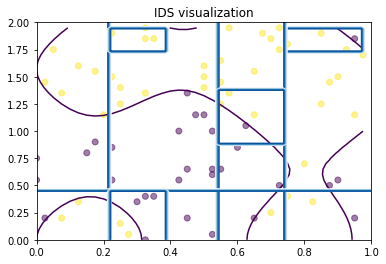

In [44]:
%matplotlib inline

from utils import  rule_to_string,ruleset_predict

print(len(explanations))

for e in explanations:
    print(rule_to_string(e,data_table.domain,target_class_idx=1))
    
our_prediction = ruleset_predict(explanations,test_data_table.X)

print(sum(our_prediction) )
print(sum(test_data_table.Y) )

import sklearn
print('Blackbox and our, acc', sklearn.metrics.accuracy_score(test_data_table.Y, our_prediction))
print('Blackbox and our, f1 score', sklearn.metrics.f1_score(test_data_table.Y, our_prediction))
print('Blackbox and our,recall', sklearn.metrics.recall_score(test_data_table.Y, our_prediction))
print('Blackbox and our,precision', sklearn.metrics.precision_score(test_data_table.Y, our_prediction))

from competition_methods_explanation.passive_methods.ids import compute_metrics_ids
compute_metrics_ids(explanations)


import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)

# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data_(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

plt.title("IDS visualization")

plt.show()


### Bayesian Rule Set

In [14]:
%load_ext autoreload
%autoreload 2


import Orange
disc = Orange.preprocess.Discretize()
# disc.method = Orange.preprocess.discretize.EntropyMDL()
disc.method = Orange.preprocess.discretize.EqualFreq(n=3)

disc_data_table = disc(data_table)
# disc_predicted_test_data_table = disc(predicted_test_data_table)
disc_test_data_table = Orange.data.Table.from_table(data_table.domain, test_data_table)
print("disc okay!")

from competition_methods_explanation.passive_methods.brs import explain_tabular
# explanations = explain_tabular_brs(data_table, black_box, target_class_idx=1, random_seed=42)
explanations,brs = explain_tabular(data_table, black_box, target_class_idx=1, random_seed=random_seed)
# explanations = explain_tabular(data_table, black_box, target_class_idx=1, random_seed=random_seed)
# from approach import explain_tabular
# explanations,explainer = explain_tabular(disc_data_table, black_box, target_class_idx=1, random_seed=random_seed,beta = 0,use_pre_mined=True, objective = 'bayesian')


from utils import  rule_to_string,ruleset_predict

print(len(explanations))

for e in explanations:
    print(rule_to_string(e,data_table.domain,target_class_idx=1))
    
our_prediction = ruleset_predict(explanations,test_data_table.X)

print(sum(our_prediction) )
print(sum(test_data_table.Y) )

import sklearn
print('Blackbox and our, acc', sklearn.metrics.accuracy_score(test_data_table.Y, our_prediction))
print('Blackbox and our, f1 score', sklearn.metrics.f1_score(test_data_table.Y, our_prediction))
print('Blackbox and our,recall', sklearn.metrics.recall_score(test_data_table.Y, our_prediction))
print('Blackbox and our,precision', sklearn.metrics.precision_score(test_data_table.Y, our_prediction))

from competition_methods_explanation.passive_methods.brs import compute_metrics_brs
compute_metrics_brs(explanations)



# explanations = explain_tabular_brs(data_table, black_box, target_class_idx=1, random_seed=42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
disc okay!
(44,)
start BRS algorithm
Generating rules using fpgrowth, of support 10 max len 2
	Took 0.000s to generate 28 rules
Screening rules using information gain
1
2
2.5
(75, 8)
(8, 28)
3
4
5
(14,)
	Took 0.008s to generate 14 rules
Computing sizes for pattern space ...
	Took 0.000s to compute patternspace
No or wrong input for alpha_l and beta_l. The model will use default parameters!
number of rules 1
error, BRS do not handle continuous feature. Something went wrong. Please discretize first
1
IF 1.2 <= y-axis <= 1.9500000000000002 THEN hit=yes 
25
37.0
Blackbox and our, acc 0.8133333333333334
Blackbox and our, f1 score 0.7741935483870968
Blackbox and our,recall 0.6486486486486487
Blackbox and our,precision 0.96
number of rules 1
ave number of conditions 1.0
max number of conditions 1
used features 1


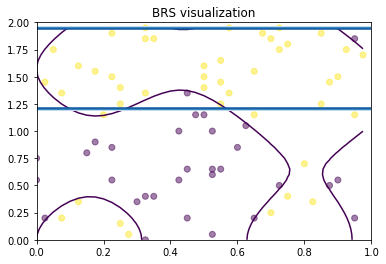

In [15]:








%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)

# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)


plt.title("BRS visualization")

plt.show()


In [ ]:
# [('y-axis_≥ 1.425',), ('x-axis_0.338 - 0.663_neg', 'x-axis_≥ 0.663')]

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)


# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
# output_rules = explanations
# for output_rule in output_rules:
#     # Z = predict_by_rule(df_instances, output_rule)
#     Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

#     Z = Z.reshape(xx.shape).astype(int)
#     CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)


# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()


## active

### DTextract

In [9]:
# %load_ext autoreload
# %autoreload 2
# from competition_methods_explanation.active_methods_top_down.uct import explain_tabular
# iter_max = 1000
# explanations, tree = explain_tabular(
#     data_table,  black_box, target_class_idx=1, random_seed=42, termination_max=iter_max)


%load_ext autoreload
%autoreload 2
from competition_methods_explanation.active_methods_top_down.dt import explain_tabular
iter_max = 1000
explanations, tree = explain_tabular(
    data_table,  black_box, target_class_idx=1, random_seed=42, active_instance_number = 20,record_synthetic=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
start estimate the distribution
using gaussian distribution
finish estimate the distribution


IF 0.0 <= x-axis <= 0.28512971191669606 AND 0.0 <= y-axis <= 0.255167462720467 THEN hit=yes 
IF 0.6435211020980909 <= x-axis <= 0.9373145067272226 AND 0.0 <= y-axis <= 0.255167462720467 THEN hit=yes 
IF 0.7224906218660735 <= x-axis <= 0.7518247148393151 AND 0.255167462720467 <= y-axis <= 0.8427616369610236 THEN hit=yes 
IF 0.7518247148393151 <= x-axis <= 0.8662797218325411 AND 0.255167462720467 <= y-axis <= 0.8427616369610236 THEN hit=yes 
IF 0.8662797218325411 <= x-axis <= 0.8800598483299398 AND 0.255167462720467 <= y-axis <= 0.8427616369610236 THEN hit=yes 
IF 0.6628248488144297 <= x-axis <= 0.9750000000000001 AND 0.8427616369610236 <= y-axis <= 1.128883718983972 THEN hit=yes 
IF 0.5400552472028745 <= x-axis <= 0.9750000000000001 AND 1.128883718983972 <= y-axis <= 1.3185470239232417 THEN hit=yes 
IF 0.036604439428412724 <= x-axis <= 0.9750000000000001 AND 1.3185470239232417 <= y-axis <= 1.9500000000000002 THEN hit=yes 
number of rules 8
40
40
37.0
Blackbox and our, acc 0.933333333333

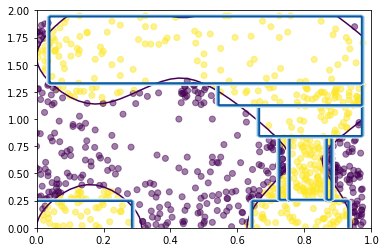

In [11]:
%matplotlib inline

from utils import  rule_to_string,ruleset_predict

for e in explanations:
    print(rule_to_string(e,data_table.domain,target_class_idx=1))
    
print("number of rules",len(explanations))
our_prediction = ruleset_predict(explanations,test_data_table.X)
tree_our_prediction = tree.predict(test_data_table.X)

print(sum(our_prediction) )
print(sum(tree_our_prediction))
print(sum(test_data_table.Y) )

import sklearn
print('Blackbox and our, acc', sklearn.metrics.accuracy_score(test_data_table.Y, our_prediction))
print('Blackbox and our, f1 score', sklearn.metrics.f1_score(test_data_table.Y, our_prediction))
print('Blackbox and our,recall', sklearn.metrics.recall_score(test_data_table.Y, our_prediction))
print('Blackbox and our,precision', sklearn.metrics.precision_score(test_data_table.Y, our_prediction))


import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
ax.scatter(tree.synthetic_X[:,0], tree.synthetic_X[:,1], c=tree.synthetic_Y , alpha=0.5)

delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)


# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)


# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()


### SP-anchor

In [22]:
%load_ext autoreload
%autoreload 2
from competition_methods_explanation.active_methods_bottom_up.cn2anchor import cn2anchor_tabular
explanations = cn2anchor_tabular(data_table, black_box, target_class_idx = 1, random_seed=42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Fail to find a rule that reaches threshold. chose best
['y-axis > 1.15', 'x-axis > 0.50']
24
22
Fail to find a rule that reaches threshold. chose best
['0.50 < x-axis <= 0.70']
75
44
['y-axis > 1.55', '0.25 < x-axis <= 0.50']
20
19
Fail to find a rule that reaches threshold. chose best
['0.50 < x-axis <= 0.70']
75
44
['0.55 < y-axis <= 1.15', 'x-axis > 0.70']
20
15
Fail to find a rule that reaches threshold. chose best
['y-axis > 1.55', 'x-axis > 0.70']
8
7
Fail to find a rule that reaches threshold. chose best
['y-axis <= 0.55', 'x-axis <= 0.25']
6
3
['0.50 < x-axis <= 0.70', 'y-axis > 1.55']
20
19
['y-axis > 1.55', 'x-axis > 0.70']
8
7
Fail to find a rule that reaches threshold. chose best
['1.15 < y-axis <= 1.55']
75
44
['0.55 < y-axis <= 1.15', 'x-axis > 0.70']
20
15
['y-axis > 1.55', '0.25 < x-axis <= 0.50']
20
19
Fail to find a rule that reaches threshold. chose best
['y-axis > 1.55']
20
19
['

IF 0.5 <= x-axis <= 0.9750000000000001 AND 1.15 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF TRUE THEN hit=yes 
IF 1.55 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF TRUE THEN hit=yes 
IF 0.7 <= x-axis <= 0.9750000000000001 THEN hit=yes 
IF 0.7 <= x-axis <= 0.9750000000000001 AND 1.55 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.0 <= x-axis <= 0.25 AND 0.0 <= y-axis <= 0.55 THEN hit=yes 
IF 1.55 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.7 <= x-axis <= 0.9750000000000001 AND 1.55 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF TRUE THEN hit=yes 
IF 0.7 <= x-axis <= 0.9750000000000001 THEN hit=yes 
IF 1.55 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 1.55 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.7 <= x-axis <= 0.9750000000000001 THEN hit=yes 
IF 0.0 <= y-axis <= 0.55 THEN hit=yes 
IF TRUE THEN hit=yes 
IF 1.55 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF TRUE THEN hit=yes 
IF TRUE THEN hit=yes 
IF 0.0 <= y-axis <= 0.55 THEN hit=yes 
75
40
37.0
Bla

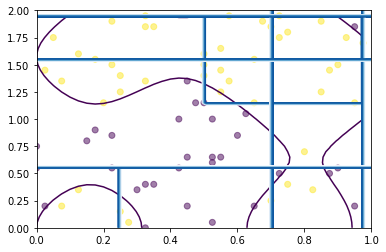

In [23]:
%matplotlib inline

from utils import  rule_to_string,ruleset_predict

for e in explanations:
    print(rule_to_string(e,data_table.domain,target_class_idx=1))
    
our_prediction = ruleset_predict(explanations,test_data_table.X)
tree_our_prediction = tree.predict(test_data_table.X)

print(sum(our_prediction) )
print(sum(tree_our_prediction))
print(sum(test_data_table.Y) )

import sklearn
print('Blackbox and our, acc', sklearn.metrics.accuracy_score(test_data_table.Y, our_prediction))
print('Blackbox and our, f1 score', sklearn.metrics.f1_score(test_data_table.Y, our_prediction))
print('Blackbox and our,recall', sklearn.metrics.recall_score(test_data_table.Y, our_prediction))
print('Blackbox and our,precision', sklearn.metrics.precision_score(test_data_table.Y, our_prediction))


import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
# ax.scatter(tree.synthetic_data_table.X[:,0], tree.synthetic_data_table.X[:,1], c=tree.synthetic_data_table.Y , alpha=0.5)

delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)


# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)


# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()



## Non-active ours

In [4]:
%load_ext autoreload
%autoreload 2
from approach import explain_tabular
iter_max = 1000
# explanations,ADS = explain_tabular(data_table, data_encoder, black_box, target_class="yes", random_seed=42,beta=0)
explanations,ADS = explain_tabular(data_table, black_box, target_class_idx=1, random_seed=42,beta=0,lambda_parameter=0.01)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
init transformer okay!
new cached!



best solution found in iteration 123
Now print Error Log
at iteration: 1 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 3 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 4 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 5 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 7 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 13 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 14 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 19 happen

IF 0.0 <= x-axis <= 0.225 AND 1.1500000000000001 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.0 <= x-axis <= 0.30000000000000004 AND 0.0 <= y-axis <= 0.5 THEN hit=yes 
IF 0.65 <= x-axis <= 0.9750000000000001 AND 0.7000000000000001 <= y-axis <= 1.7550000000000001 THEN hit=yes 
IF 0.7000000000000001 <= x-axis <= 0.8287500000000002 AND 0.0 <= y-axis <= 1.2675 THEN hit=yes 
IF 1.25 <= y-axis <= 1.9500000000000002 THEN hit=yes 
44
37.0
Blackbox and our, acc 0.8533333333333334
Blackbox and our, f1 score 0.8641975308641975
Blackbox and our,recall 0.9459459459459459
Blackbox and our,precision 0.7954545454545454


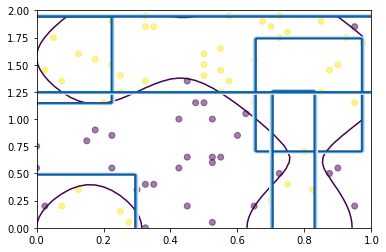

number of rules: 5
IF 0.0 <= x-axis <= 0.225 AND 1.1500000000000001 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.0 <= x-axis <= 0.30000000000000004 AND 0.0 <= y-axis <= 0.5 THEN hit=yes 
IF 0.65 <= x-axis <= 0.9750000000000001 AND 0.7000000000000001 <= y-axis <= 1.7550000000000001 THEN hit=yes 
IF 0.7000000000000001 <= x-axis <= 0.8287500000000002 AND 0.0 <= y-axis <= 1.2675 THEN hit=yes 
IF 1.25 <= y-axis <= 1.9500000000000002 THEN hit=yes 


In [5]:
%matplotlib inline

ADS.finish()
# clean the cache

from utils import  rule_to_string,ruleset_predict

for e in explanations:
    print(rule_to_string(e,data_table.domain,target_class_idx=1))
    
our_prediction = ruleset_predict(explanations,test_data_table.X)

print(sum(our_prediction) )
print(sum(test_data_table.Y) )

import sklearn
print('Blackbox and our, acc', sklearn.metrics.accuracy_score(test_data_table.Y, our_prediction))
print('Blackbox and our, f1 score', sklearn.metrics.f1_score(test_data_table.Y, our_prediction))
print('Blackbox and our,recall', sklearn.metrics.recall_score(test_data_table.Y, our_prediction))
print('Blackbox and our,precision', sklearn.metrics.precision_score(test_data_table.Y, our_prediction))


import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
# ax.scatter(ADS.synthetic_data_table.X[:,0], ADS.synthetic_data_table.X[:,1], c=ADS.synthetic_data_table.Y , alpha=0.5)

delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)


# # visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data_(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

plt.show()

from utils import  rule_to_string
print('number of rules:',len(explanations))
for e in explanations:
    print(rule_to_string(e,data_table.domain,1))

## Ours

In [7]:
from approach import explain_tabular
# iter_max = 1000
beta = 1e-4
# beta = 5e-5


# beta = 0
explanations,ADS = explain_tabular(data_table, black_box, target_class_idx=1, random_seed=42,beta=beta,lambda_parameter=0.01)
# explanations,ADS = explain_tabular(data_table, black_box, target_class="yes", random_seed=42,beta=1)

init transformer okay!
new cached!


best solution found in iteration 224
Now print Error Log
at iteration: 1 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 3 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 4 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 5 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 7 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 13 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 14 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 32 happens

IF 0.0 <= x-axis <= 0.28253859754331834 AND 0.0 <= y-axis <= 0.33498176489324183 THEN hit=yes 
IF 0.07168010323697038 <= x-axis <= 0.9750000000000001 AND 1.1700000000000004 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.590023008427765 <= x-axis <= 0.9750000000000001 AND 0.9149497512082946 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.6421690998389374 <= x-axis <= 0.9750000000000001 AND 0.0 <= y-axis <= 0.19500000000000003 THEN hit=yes 
IF 0.7312500000000001 <= x-axis <= 0.8775000000000001 AND 0.0 <= y-axis <= 0.9750000000000001 THEN hit=yes 
37
37.0
number of generated instances 242
Blackbox and our, acc 0.9466666666666667
Blackbox and our, f1 score 0.9459459459459459
Blackbox and our,recall 0.9459459459459459
Blackbox and our,precision 0.9459459459459459


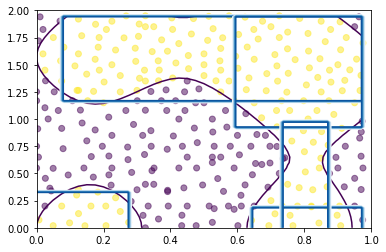

number of rules: 5
IF 0.0 <= x-axis <= 0.28253859754331834 AND 0.0 <= y-axis <= 0.33498176489324183 THEN hit=yes 
IF 0.07168010323697038 <= x-axis <= 0.9750000000000001 AND 1.1700000000000004 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.590023008427765 <= x-axis <= 0.9750000000000001 AND 0.9149497512082946 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.6421690998389374 <= x-axis <= 0.9750000000000001 AND 0.0 <= y-axis <= 0.19500000000000003 THEN hit=yes 
IF 0.7312500000000001 <= x-axis <= 0.8775000000000001 AND 0.0 <= y-axis <= 0.9750000000000001 THEN hit=yes 


In [8]:
%matplotlib inline
ADS.finish()
from utils import  rule_to_string,ruleset_predict
for e in explanations:
    print(rule_to_string(e,data_table.domain,target_class_idx=1))
    
our_prediction = ruleset_predict(explanations,test_data_table.X)

print(sum(our_prediction) )
print(sum(test_data_table.Y) )

print("number of generated instances",ADS.synthetic_data_table.X.shape[0])
import sklearn
print('Blackbox and our, acc', sklearn.metrics.accuracy_score(test_data_table.Y, our_prediction))
print('Blackbox and our, f1 score', sklearn.metrics.f1_score(test_data_table.Y, our_prediction))
print('Blackbox and our,recall', sklearn.metrics.recall_score(test_data_table.Y, our_prediction))
print('Blackbox and our,precision', sklearn.metrics.precision_score(test_data_table.Y, our_prediction))




import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
ax.scatter(ADS.synthetic_data_table.X[:,0], ADS.synthetic_data_table.X[:,1], c=ADS.synthetic_data_table.Y , alpha=0.5)


delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)

# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()

from utils import  rule_to_string
print('number of rules:',len(explanations))
for e in explanations:
    print(rule_to_string(e,data_table.domain,1))

init transformer okay!
new cached!


best solution found in iteration 577
Now print Error Log
at iteration: 1 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 3 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 4 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 5 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 7 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 13 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 14 happens the following error
('no plausible actions, len length of actions', 0, 'in the mode of ', 'ADD_CONDITION')
at iteration: 19 happens

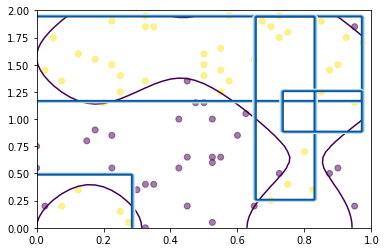

number of rules: 4
IF 0.0 <= x-axis <= 0.2925000000000001 AND 0.0 <= y-axis <= 0.5 THEN hit=yes 
IF 0.0 <= x-axis <= 0.9750000000000001 AND 1.1700000000000004 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.65 <= x-axis <= 0.8287500000000002 AND 0.25 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.7312500000000001 <= x-axis <= 0.9750000000000001 AND 0.875 <= y-axis <= 1.2675 THEN hit=yes 


In [10]:
from approach import explain_tabular
# iter_max = 1000
# beta = 1e-4
beta = 0
explanations,ADS = explain_tabular(data_table, black_box, target_class_idx=1, random_seed=42,beta=beta,lambda_parameter=0.01)
# explanations,ADS = explain_tabular(data_table, black_box, target_class="yes", random_seed=42,beta=1)
%matplotlib inline
ADS.finish()
from utils import  rule_to_string,ruleset_predict
for e in explanations:
    print(rule_to_string(e,data_table.domain,target_class_idx=1))
    
our_prediction = ruleset_predict(explanations,test_data_table.X)

print(sum(our_prediction) )
print(sum(test_data_table.Y) )

print("number of generated instances",ADS.synthetic_data_table.X.shape[0])
import sklearn
print('Blackbox and our, acc', sklearn.metrics.accuracy_score(test_data_table.Y, our_prediction))
print('Blackbox and our, f1 score', sklearn.metrics.f1_score(test_data_table.Y, our_prediction))
print('Blackbox and our,recall', sklearn.metrics.recall_score(test_data_table.Y, our_prediction))
print('Blackbox and our,precision', sklearn.metrics.precision_score(test_data_table.Y, our_prediction))




import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
ax.scatter(ADS.synthetic_data_table.X[:,0], ADS.synthetic_data_table.X[:,1], c=ADS.synthetic_data_table.Y , alpha=0.5)


delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)

# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()

from utils import  rule_to_string
print('number of rules:',len(explanations))
for e in explanations:
    print(rule_to_string(e,data_table.domain,1))